# Lab 9: Logistic Regression

## *Stay Linear while Powerful*

### Based on Neil D. Lawrence MLAI2015 version and notebook from scikit-learn 
### Modified by Haiping Lu on 23 November 2018

In [1]:
import numpy as np
import pandas as pd
import pods
import matplotlib.pyplot as plt
%matplotlib inline


/home/haiping/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


The naive Bayes assumption allowed us to specify a class conditional density, $p(\mathbf{x}_i|y_i, \boldsymbol{\theta})$, through assuming that the features were conditionally independent given the label. Combined with our assumption that the data points are conditionally independent given the parameters, $\boldsymbol{\theta}$, this allowed us to specify a joint density over the entire data set, $p(\mathbf{y}, \mathbf{X})$. We argued that modeling the joint density is a powerful approach because we can answer any particular question we have about the data through the sum rule and the product rule of probability. We can condition on the training data and query the value of an unseen test point. If we have missing data, then we can integrate over the missing point (marginalise) and obtain our best prediction despite the absence of some of the features for a point. However, it comes at the cost of a particular modeling assumption. Namely, to make modeling practical we assumed that the features were conditionally independent given the feature label. In other words, for any given point, if we know its class, then its features will be independent. This is a very strong assumption. For example, if we were classifying the sex of an individual given their height and weight, naive Bayes would assume that if we knew their sex, then the height and weight would be independent. This is clearly wrong, the dependence between height and weight is not dictated only by the sex of an individual, there is a natural correlation between them.

Modeling the entire joint density allows us to deal with different questions, that we may not have envisaged at the model *design time*. It contrasts with the approach we took for regression where we specifically chose to model the conditional density for the target values, $\mathbf{y}$, given the input locations, $\mathbf{X}$. That density, $p(\mathbf{y}|\mathbf{X})$, effectively assumes that the question we'll be asked at *run time* is known. In particular, we expect to be asked about the value of the function, $y^*$, given a particular input location, $\mathbf{x}^*$. We don't expect to be asked about the value of an input given a particular observation. That would require placing an additional prior over the input location for each point, $p(\mathbf{x}_i)$. Of course, it's possible to conceive of a model like this, and indeed that is how we proceeded for dimensionality reduction. However, if we know we will always have all the inputs at run time, it may make sense to *directly* model the conditional density, $p(\mathbf{y}|\mathbf{X})$. 

## Logistic Regression

A logistic regression is an approach to classification which extends the linear basis function models we've already explored. Rather than modeling the output of the function directly the assumption is that we model the *log-odds* with the basis functions.

The [odds](http://en.wikipedia.org/wiki/Odds) are defined as the ratio of the probability of a positive outcome, to the probability of a negative outcome. If the probability of a positive outcome is denoted by $\pi$, then the odds are computed as $\frac{\pi}{1-\pi}$. Odds are widely used by [bookmakers](http://en.wikipedia.org/wiki/Bookmaker) in gambling, although a bookmakers odds won't normalise: i.e. if you look at the equivalent probabilities, and sum over the probability of all outcomes the bookmakers are considering, then you won't get one. This is how the bookmaker makes a profit. 

Because a probability is always between zero and one, the odds are always between $0$ and $\infty$. If the positive outcome is unlikely the odds are close to zero, if it is very likely then the odds become close to infinite. Taking the logarithm of the odds maps the odds from the positive half space to being across the entire real line. Odds that were between 0 and 1 (where the negative outcome was more likely) are mapped to the range between $-\infty$ and $0$. Odds that are greater than 1 are mapped to the range between $0$ and $\infty$. Considering the log odds therefore takes a number between 0 and 1 (the probability of positive outcome) and maps it to the entire real line. The function that does this is known as the [logit function](http://en.wikipedia.org/wiki/Logit),
$
g^{-1}(p_i) = \log\frac{p_i}{1-p_i}
$
This function is known as a *link function*.

For a standard regression we take,
$$
f(x) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}),
$$
if we want to perform classification we perform a logistic regression. 
$$
\log \frac{\pi}{(1-\pi)} = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
where the odds ratio between the positive class and the negative class is given by
$$
\frac{\pi}{(1-\pi)}
$$
The odds can never be negative, but can take any value from 0 to $\infty$. We have defined the link function as taking the form $g^{-1}(\cdot)$ implying that the inverse link function is given by $g(\cdot)$. Since we have defined,
$$
g^{-1}(\pi) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
we can write $\pi$ in terms of the *inverse link* function, $g(\cdot)$ as 
$$
\pi = g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})).
$$

### Basis Function

We'll define our prediction, objective and gradient functions below. But before we start, we need to define a basis function for our model. Let's start with the linear basis.

In [2]:
def linear(x, **kwargs):
    "Defines the linear basis."
    return np.hstack([np.ones((X.shape[0], 1)), X])

### Prediction Function

Now we have the basis function let's define the prediction function.

In [3]:
def predict(w, x, basis=linear, **kwargs):
    "Generates the prediction function and the basis matrix."
    Phi = basis(x, **kwargs)
    f = np.dot(Phi, w)
    return 1./(1+np.exp(-f)), Phi

This inverse of the link function is known as the [logistic](http://en.wikipedia.org/wiki/Logistic_function) (thus the name logistic regression) or sometimes it is called the sigmoid function. For a particular value of the input to the link function, $f_i = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$ we can plot the value of the link function as below.

Text(0,0.5,'$g_i$')

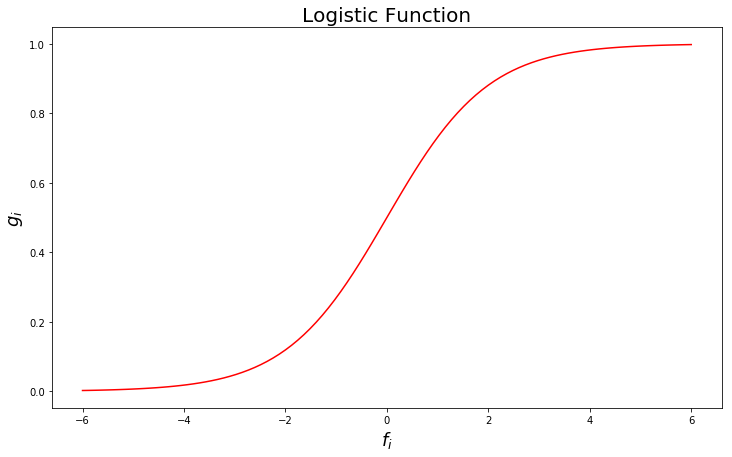

In [4]:
fig, ax = plt.subplots(figsize=(12, 7))
f = np.linspace(-6, 6, 100)
g = 1/(1+np.exp(-f))
ax.plot(f, g, 'r-')
ax.set_title('Logistic Function', fontsize=20)
ax.set_xlabel('$f_i$', fontsize=18)
ax.set_ylabel('$g_i$', fontsize=18)

The function has this characeristic 's'-shape (from where the term sigmoid, as in sigma, comes from). It also takes the input from the entire real line and 'squashes' it into an output that is between zero and one. For this reason it is sometimes also called a 'squashing function'. 

By replacing the inverse link with the sigmoid we can write $\pi$ as a function of the input and the parameter vector as, 
$$
\pi(\mathbf{x},\mathbf{w}) = \frac{1}{1+ \exp\left(-\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}.
$$

The process for logistic regression is as follows. Compute the output of a standard linear basis function composition ($\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})$, as we did for linear regression) and then apply the inverse link function, $g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}))$. In logistic regression this involves *squashing* it with the logistic (or sigmoid) function. Use this value, which now has an interpretation as a *probability* in a Bernoulli distribution to form the likelihood. Then we can assume conditional independence of each data point given the parameters and develop a likelihod for the entire data set. 

As we discussed last time, the Bernoulli likelihood is of the form,
$$
P(y_i|\mathbf{w}, \mathbf{x}) = \pi_i^{y_i} (1-\pi_i)^{1-y_i}
$$
which we can think of as clever trick for mathematically switching between two probabilities if we were to write it as code it would be better described as
```python
def bernoulli(x, y, pi):
    if y == 1:
        return pi(x)
    else:
        return 1-pi(x)
```
but writing it mathematically makes it easier to write our objective function within a single mathematical equation. 

## Maximum Likelihood

To obtain the parameters of the model, we need to maximize the likelihood, or minimize the objective function, normally taken to be the negative log likelihood. With a data conditional independence assumption the likelihood has the form,
$$
P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^n P(y_i|\mathbf{w}, \mathbf{x}_i). 
$$
which can be written as a log likelihood in the form
$$
\log P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^n \log P(y_i|\mathbf{w}, \mathbf{x}_i) = \sum_{i=1}^n y_i \log \pi_i + \sum_{i=1}^n (1-y_i)\log (1-\pi_i)
$$
and if we take the probability of positive outcome for the $i$th data point to be given by
$$
\pi_i = g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right),
$$
where $g(\cdot)$ is the *inverse* link function, then this leads to an objective function of the form,
$$
E(\mathbf{w}) = -  \sum_{i=1}^n y_i \log g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right) - \sum_{i=1}^n(1-y_i)\log \left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right)\right).
$$

In [5]:
def objective(g, y):
    "Computes the objective function."
    posind = np.where(y.flatten()==1)
    negind = np.where(y.flatten()==0)
    return -np.log(g[posind, :]).sum() - np.log(1-g[negind, :]).sum()


As normal, we would like to minimize this objective. This can be done by differentiating with respect to the parameters of our prediction function, $\pi(\mathbf{x};\mathbf{w})$, for optimisation. The gradient of the likelihood with respect to $\pi(\mathbf{x};\mathbf{w})$ is of the form,
$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n \frac{y_i}{g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n \frac{1-y_i}{1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)}
$$
where we used the chain rule to develop the derivative in terms of $\frac{\text{d}g(f_i)}{\text{d}f_i}$, which is the gradient of the inverse link function (in our case the gradient of the sigmoid function).

So the objective function now depends on the gradient of the inverse link function, as well as the likelihood depends on the gradient of the inverse link function, as well as the gradient of the log likelihood, and naturally the gradient of the argument of the inverse link function with respect to the parameters, which is simply $\boldsymbol{\phi}(\mathbf{x}_i)$.

The only missing term is the gradient of the inverse link function. For the sigmoid squashing function we have,
\begin{align*}
g(f_i) &= \frac{1}{1+\exp(-f_i)}\\
&=(1+\exp(-f_i))^{-1}
\end{align*}
and the gradient can be computed as
\begin{align*}
\frac{\text{d}g(f_i)}{\text{d} f_i} & = \exp(-f_i)(1+\exp(-f_i))^{-2}\\
& = \frac{1}{1+\exp(-f_i)} \frac{\exp(-f_i)}{1+\exp(-f_i)} \\
& = g(f_i) (1-g(f_i))
\end{align*}
so the full gradient can be written down as
$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n y_i\left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n (1-y_i)\left(g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)}.
$$

In [6]:
def gradient(g, Phi, y):
    "Generates the gradient of the parameter vector."
    posind = np.where(y.flatten()==1)
    dw = -(Phi[posind]*(1-g[posind])).sum(0)
    negind = np.where(y.flatten()==0 )
    dw += (Phi[negind]*g[negind]).sum(0)
    return dw[:, None]

## Optimization of the Function

Reorganizing the gradient to find a stationary point of the function with respect to the parameters $\mathbf{w}$ turns out to be impossible. Optimization has to proceed by *numerical methods*. Options include the multidimensional variant of [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method) or [gradient based optimization methods](http://en.wikipedia.org/wiki/Gradient_method) like we used for optimizing matrix factorization for the movie recommender system. We recall from matrix factorization that, for large data, *stochastic gradient descent* or the Robbins Munroe optimization procedure worked best for function minimization. 

## [MNIST classfification using multinomial logistic + L1](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html)

Here we fit a multinomial logistic regression with L1 penalty on a subset of
the MNIST digits classification task. We use the SAGA algorithm for this
purpose: this a solver that is fast when the number of samples is significantly
larger than the number of features and is able to finely optimize non-smooth
objective functions which is the case with the l1-penalty. Test accuracy
reaches > 0.8, while weight vectors remains *sparse* and therefore more easily
*interpretable*.

Note that this accuracy of this l1-penalized linear model is significantly
below what can be reached by an l2-penalized linear model or a non-linear
multi-layer perceptron model on this dataset.

[scikit-learn documentation on logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

Note the following notebook needs scikit-learn 0.20.0 and up. To upgrade: <code>pip install -U scikit-learn
</code>

In [7]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.1.


Automatically created module for IPython interactive environment
Sparsity with L1 penalty: 80.59%
Test score with L1 penalty: 0.8337
Example run in 25.269 s


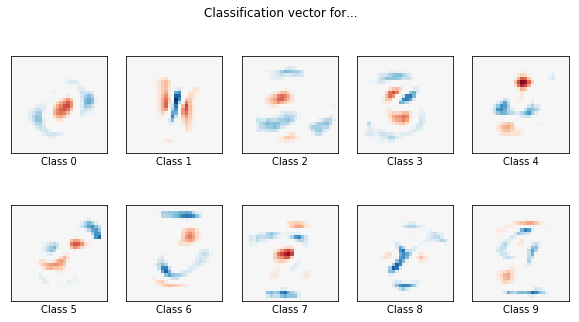

In [8]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / train_samples,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

### Exercise

Now you can run PCA and logistic regression on the same set of data (here or in lab 7) to compare the features from unsupervised and supervised learning.

## Going Further

### Optimization

Other optimization techniques for generalized linear models include [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method), it requires you to compute the Hessian, or second derivative of the objective function. 

Methods that are based on gradients only include [L-BFGS](http://en.wikipedia.org/wiki/Limited-memory_BFGS) and [conjugate gradients](http://en.wikipedia.org/wiki/Conjugate_gradient_method). Can you find these in python? Are they suitable for very large data sets? 

### GLMs

[Generalized linear models at scikit learn](https://scikit-learn.org/stable/modules/linear_model.html#)



